In [8]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


Set GPU memory limit to 16GB.
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


In [9]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [10]:
num_classes = 11
def filter_invalid_labels(image, label):
    # Exclude labels that are less than 0 or greater than the maximum allowed class
    valid_labels = tf.reduce_all(label >= 0) & tf.reduce_all(label < num_classes)
    return valid_labels

In [11]:
base_path = '/home/workspace/geometry-classifier/data/'

def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x3
    class_label = tf.cast(name[0], tf.int32)  # Use the first byte as a class label
    return image, class_label

def load_tfrecord(tfrecord_files):
    """Load TFRecords and prepare a dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

# Directory with TFRecords

files_for = lambda file_type: glob.glob(f"{base_path}/tfr_strat50-1min/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")


print(glob.glob(f"{base_path}tfr_strat50-1min/*.tfrecord.gz")[0])

test = load_tfrecord(test_files).filter(filter_invalid_labels)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

validation = load_tfrecord(validation_files).filter(filter_invalid_labels)
validation = validation.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files).filter(filter_invalid_labels)
train = train.shuffle(23360).batch(32).prefetch(tf.data.AUTOTUNE)



/home/workspace/geometry-classifier/data/tfr_strat50-1min/train153.tfrecord.gz


2024-11-23 20:14:10.997029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16384 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:23:00.0, compute capability: 7.5


In [12]:
# 224 x 224

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(11, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
checkpoint_callback = ModelCheckpoint(base_path+'model4.keras',save_best_only=True, save_weights_only=False, mode='min', verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss",       # Monitor validation loss
    patience=10,
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

epochs = 100

In [14]:

cnn = model.fit(train, epochs=epochs,callbacks=[
    early_stopping,
    checkpoint_callback
], validation_data=validation)

Epoch 1/100


2024-11-23 20:14:24.195597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11977 of 23360
2024-11-23 20:14:32.120774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1732392872.169702     359 service.cc:146] XLA service 0x7f61fc006660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732392872.169763     359 service.cc:154]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-11-23 20:14:32.247535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 20:14:32.685480: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


      8/Unknown 24s 20ms/step - accuracy: 0.1616 - loss: 2.3923

I0000 00:00:1732392876.130814     359 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   7480/Unknown 219s 26ms/step - accuracy: 0.4132 - loss: 1.7097

2024-11-23 20:17:50.785314: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-23 20:17:50.785399: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 20:17:50.785422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:17:50.785447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, tra


Epoch 1: val_loss improved from inf to 1.44118, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 287s 35ms/step - accuracy: 0.4132 - loss: 1.7097 - val_accuracy: 0.4921 - val_loss: 1.4412
Epoch 2/100


2024-11-23 20:18:59.367473: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 20:18:59.367605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:18:59.367641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:19:10.848174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 13139 of 23360


   8/7480 ━━━━━━━━━━━━━━━━━━━━ 2:28 20ms/step - accuracy: 0.5470 - loss: 1.2430  

2024-11-23 20:19:19.575735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7475/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5789 - loss: 1.1836

2024-11-23 20:22:13.386943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:22:13.387053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 2: val_loss improved from 1.44118 to 1.18998, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 259s 32ms/step - accuracy: 0.5789 - loss: 1.1836 - val_accuracy: 0.6108 - val_loss: 1.1900
Epoch 3/100


2024-11-23 20:23:18.294327: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 20:23:18.294434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:23:18.294480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:23:29.383964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11464 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:34 21ms/step - accuracy: 0.5978 - loss: 1.1222  

2024-11-23 20:23:38.871996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6434 - loss: 1.0017

2024-11-23 20:26:37.539040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:26:37.539239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 3: val_loss improved from 1.18998 to 1.06452, saving model to /home/workspace/geometry-classifier/data/model4.keras


2024-11-23 20:27:47.731280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 269s 33ms/step - accuracy: 0.6434 - loss: 1.0017 - val_accuracy: 0.6489 - val_loss: 1.0645
Epoch 4/100


2024-11-23 20:27:58.460470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12678 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:33 21ms/step - accuracy: 0.6130 - loss: 1.1233  

2024-11-23 20:28:06.917253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7476/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6838 - loss: 0.8913
Epoch 4: val_loss improved from 1.06452 to 1.01012, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 250s 31ms/step - accuracy: 0.6838 - loss: 0.8913 - val_accuracy: 0.6668 - val_loss: 1.0101
Epoch 5/100


2024-11-23 20:31:57.655837: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 20:31:57.655981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:31:57.656022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:32:08.389764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11335 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:37 21ms/step - accuracy: 0.7692 - loss: 0.7904  

2024-11-23 20:32:17.237214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7102 - loss: 0.8168
Epoch 5: val_loss improved from 1.01012 to 0.94805, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 270s 33ms/step - accuracy: 0.7102 - loss: 0.8168 - val_accuracy: 0.6908 - val_loss: 0.9481
Epoch 6/100


2024-11-23 20:36:27.298203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:36:27.298361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:36:37.865578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12263 of 23360


   6/7480 ━━━━━━━━━━━━━━━━━━━━ 2:58 24ms/step - accuracy: 0.7305 - loss: 0.7803  

2024-11-23 20:36:46.078861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7298 - loss: 0.7615
Epoch 6: val_loss improved from 0.94805 to 0.92984, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 267s 33ms/step - accuracy: 0.7298 - loss: 0.7615 - val_accuracy: 0.6904 - val_loss: 0.9298
Epoch 7/100


2024-11-23 20:40:53.918017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:40:53.918188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:41:04.369024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11306 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:29 20ms/step - accuracy: 0.7172 - loss: 0.6873  

2024-11-23 20:41:13.237887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7476/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7446 - loss: 0.7189

2024-11-23 20:44:10.177500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:44:10.177646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 7: val_loss improved from 0.92984 to 0.90447, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 259s 32ms/step - accuracy: 0.7446 - loss: 0.7189 - val_accuracy: 0.7048 - val_loss: 0.9045
Epoch 8/100


2024-11-23 20:45:13.321872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:45:13.322011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:45:23.617008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12414 of 23360


   8/7480 ━━━━━━━━━━━━━━━━━━━━ 2:34 21ms/step - accuracy: 0.6541 - loss: 0.8952  

2024-11-23 20:45:31.672387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7479/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7573 - loss: 0.6797

2024-11-23 20:48:18.269719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:48:18.269832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 8: val_loss improved from 0.90447 to 0.84806, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 250s 31ms/step - accuracy: 0.7573 - loss: 0.6797 - val_accuracy: 0.7186 - val_loss: 0.8481
Epoch 9/100


2024-11-23 20:49:23.130279: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 20:49:23.130430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:49:23.130478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:49:33.343392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12363 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:33 21ms/step - accuracy: 0.7345 - loss: 0.6930  

2024-11-23 20:49:41.453148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7683 - loss: 0.6494

2024-11-23 20:52:27.590543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:52:27.590674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 9: val_loss improved from 0.84806 to 0.84145, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 247s 31ms/step - accuracy: 0.7683 - loss: 0.6494 - val_accuracy: 0.7242 - val_loss: 0.8415
Epoch 10/100


2024-11-23 20:53:29.732030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:53:39.997321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12317 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:33 21ms/step - accuracy: 0.7778 - loss: 0.6703  

2024-11-23 20:53:48.166400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7475/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7763 - loss: 0.6254

2024-11-23 20:56:55.601391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:56:55.601578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 10: val_loss improved from 0.84145 to 0.80143, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 276s 34ms/step - accuracy: 0.7763 - loss: 0.6254 - val_accuracy: 0.7377 - val_loss: 0.8014
Epoch 11/100


2024-11-23 20:58:05.453674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 20:58:05.453823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 20:58:15.665816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12256 of 23360


   3/7480 ━━━━━━━━━━━━━━━━━━━━ 3:48 31ms/step - accuracy: 0.8628 - loss: 0.4047   

2024-11-23 20:58:24.046753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7479/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7846 - loss: 0.6050

2024-11-23 21:01:09.381095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 11: val_loss did not improve from 0.80143
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 247s 31ms/step - accuracy: 0.7846 - loss: 0.6050 - val_accuracy: 0.7368 - val_loss: 0.8064
Epoch 12/100


2024-11-23 21:02:22.933341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12319 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:34 21ms/step - accuracy: 0.7295 - loss: 0.8377  

2024-11-23 21:02:31.101576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7476/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7899 - loss: 0.5900
Epoch 12: val_loss did not improve from 0.80143
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 291s 37ms/step - accuracy: 0.7899 - loss: 0.5900 - val_accuracy: 0.7418 - val_loss: 0.8053
Epoch 13/100


2024-11-23 21:07:04.264859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:07:04.265000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:07:14.468614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12443 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:38 21ms/step - accuracy: 0.8140 - loss: 0.6516  

2024-11-23 21:07:22.558802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7474/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7938 - loss: 0.5722

2024-11-23 21:10:29.999414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:10:29.999523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 13: val_loss improved from 0.80143 to 0.79710, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 271s 34ms/step - accuracy: 0.7938 - loss: 0.5722 - val_accuracy: 0.7477 - val_loss: 0.7971
Epoch 14/100


2024-11-23 21:11:34.797441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:11:34.797540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:11:45.099349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12328 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:36 21ms/step - accuracy: 0.7491 - loss: 0.6657  

2024-11-23 21:11:53.285522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7995 - loss: 0.5602

2024-11-23 21:14:46.824686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:14:46.824810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 14: val_loss improved from 0.79710 to 0.79544, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 255s 32ms/step - accuracy: 0.7995 - loss: 0.5603 - val_accuracy: 0.7462 - val_loss: 0.7954
Epoch 15/100


2024-11-23 21:15:50.014469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:15:50.014631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:16:00.315893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 13890 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:48 23ms/step - accuracy: 0.8045 - loss: 0.6311  

2024-11-23 21:16:07.068121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8049 - loss: 0.5444
Epoch 15: val_loss improved from 0.79544 to 0.76277, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 260s 32ms/step - accuracy: 0.8049 - loss: 0.5445 - val_accuracy: 0.7553 - val_loss: 0.7628
Epoch 16/100


2024-11-23 21:20:10.016684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:20:10.016799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:20:20.252356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11325 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:30 20ms/step - accuracy: 0.8133 - loss: 0.5620  

2024-11-23 21:20:29.126798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7474/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8096 - loss: 0.5311

2024-11-23 21:23:42.716818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:23:42.716942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 16: val_loss improved from 0.76277 to 0.76139, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 285s 36ms/step - accuracy: 0.8096 - loss: 0.5311 - val_accuracy: 0.7571 - val_loss: 0.7614
Epoch 17/100


2024-11-23 21:24:55.244530: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 21:24:55.244679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:24:55.244710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:25:05.448494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11498 of 23360
2024-11-23 21:25:15.448973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 22774 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:30 20ms/step - accuracy: 0.7756 - loss: 0.6400  

2024-11-23 21:25:15.886979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7475/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8127 - loss: 0.5225
Epoch 17: val_loss did not improve from 0.76139
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 270s 33ms/step - accuracy: 0.8127 - loss: 0.5225 - val_accuracy: 0.7561 - val_loss: 0.7665
Epoch 18/100


2024-11-23 21:29:24.871532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:29:24.871675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:29:34.952868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12315 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:33 21ms/step - accuracy: 0.8703 - loss: 0.4222  

2024-11-23 21:29:43.127420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7475/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8193 - loss: 0.5065
Epoch 18: val_loss improved from 0.76139 to 0.74791, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 263s 33ms/step - accuracy: 0.8193 - loss: 0.5065 - val_accuracy: 0.7637 - val_loss: 0.7479
Epoch 19/100


2024-11-23 21:33:47.420935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:33:47.421055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:33:57.673319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 9446 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:36 21ms/step - accuracy: 0.8723 - loss: 0.3857  

2024-11-23 21:34:07.989892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8221 - loss: 0.4936

2024-11-23 21:36:58.611450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:36:58.611598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 19: val_loss did not improve from 0.74791
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 258s 32ms/step - accuracy: 0.8221 - loss: 0.4936 - val_accuracy: 0.7602 - val_loss: 0.7684
Epoch 20/100


2024-11-23 21:38:05.325570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:38:05.325699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:38:15.421959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12341 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:35 21ms/step - accuracy: 0.8590 - loss: 0.4305  

2024-11-23 21:38:23.518808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7479/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8254 - loss: 0.4836

2024-11-23 21:41:22.311126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 20: val_loss improved from 0.74791 to 0.74757, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 262s 33ms/step - accuracy: 0.8254 - loss: 0.4836 - val_accuracy: 0.7655 - val_loss: 0.7476
Epoch 21/100


2024-11-23 21:42:26.966207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:42:26.966387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:42:37.259573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 10843 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:39 21ms/step - accuracy: 0.7992 - loss: 0.5567  

2024-11-23 21:42:46.808300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7479/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8281 - loss: 0.4752

2024-11-23 21:45:48.119446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:45:48.119601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 21: val_loss did not improve from 0.74757
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 262s 32ms/step - accuracy: 0.8281 - loss: 0.4752 - val_accuracy: 0.7680 - val_loss: 0.7570
Epoch 22/100


2024-11-23 21:46:48.624596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:46:48.624688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:46:58.712708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11379 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:39 21ms/step - accuracy: 0.8106 - loss: 0.4612  

2024-11-23 21:47:08.408290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8324 - loss: 0.4644

2024-11-23 21:49:56.616859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:49:56.617012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 22: val_loss improved from 0.74757 to 0.73098, saving model to /home/workspace/geometry-classifier/data/model4.keras
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 253s 31ms/step - accuracy: 0.8324 - loss: 0.4644 - val_accuracy: 0.7723 - val_loss: 0.7310
Epoch 23/100


2024-11-23 21:51:01.295746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:51:01.295908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:51:11.471931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 13471 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:37 21ms/step - accuracy: 0.8785 - loss: 0.3458  

2024-11-23 21:51:18.742644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7477/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8365 - loss: 0.4553

2024-11-23 21:54:08.472082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:54:08.472210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 23: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 250s 31ms/step - accuracy: 0.8365 - loss: 0.4553 - val_accuracy: 0.7700 - val_loss: 0.7621
Epoch 24/100


2024-11-23 21:55:10.962153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:55:10.962284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 21:55:21.106176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12379 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:36 21ms/step - accuracy: 0.7712 - loss: 0.7373  

2024-11-23 21:55:29.234739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7475/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8375 - loss: 0.4517

2024-11-23 21:58:36.985104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:58:36.985250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 24: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 280s 35ms/step - accuracy: 0.8375 - loss: 0.4517 - val_accuracy: 0.7725 - val_loss: 0.7468
Epoch 25/100


2024-11-23 21:59:50.752515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 21:59:50.752652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:00:00.845599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12334 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:35 21ms/step - accuracy: 0.8068 - loss: 0.5636  

2024-11-23 22:00:09.801153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7474/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8408 - loss: 0.4425

2024-11-23 22:02:55.617544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:02:55.617712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 25: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 254s 31ms/step - accuracy: 0.8408 - loss: 0.4425 - val_accuracy: 0.7681 - val_loss: 0.7558
Epoch 26/100


2024-11-23 22:04:04.442898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:04:14.525904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12347 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:39 21ms/step - accuracy: 0.8236 - loss: 0.4393  

2024-11-23 22:04:22.674464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7476/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8440 - loss: 0.4328
Epoch 26: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 281s 35ms/step - accuracy: 0.8440 - loss: 0.4328 - val_accuracy: 0.7673 - val_loss: 0.7622
Epoch 27/100


2024-11-23 22:08:45.196631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:08:45.196820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:08:55.306480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11275 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:37 21ms/step - accuracy: 0.7957 - loss: 0.4933  

2024-11-23 22:09:04.289912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7476/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8466 - loss: 0.4236
Epoch 27: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 256s 32ms/step - accuracy: 0.8466 - loss: 0.4236 - val_accuracy: 0.7806 - val_loss: 0.7410
Epoch 28/100


2024-11-23 22:13:00.996298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:13:00.996426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:13:11.081801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 10319 of 23360
2024-11-23 22:13:21.081994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 20992 of 23360


   8/7480 ━━━━━━━━━━━━━━━━━━━━ 2:26 20ms/step - accuracy: 0.8675 - loss: 0.4634  

2024-11-23 22:13:22.801339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8487 - loss: 0.4192

2024-11-23 22:16:11.095509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:16:11.095651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 28: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 255s 31ms/step - accuracy: 0.8487 - loss: 0.4192 - val_accuracy: 0.7721 - val_loss: 0.7885
Epoch 29/100


2024-11-23 22:17:16.340468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:17:26.405693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11489 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:38 21ms/step - accuracy: 0.8406 - loss: 0.3748  

2024-11-23 22:17:35.211109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7474/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8510 - loss: 0.4119

2024-11-23 22:20:28.717870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:20:28.718036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 29: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 256s 32ms/step - accuracy: 0.8509 - loss: 0.4119 - val_accuracy: 0.7827 - val_loss: 0.7433
Epoch 30/100


2024-11-23 22:21:31.954639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:21:31.954788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:21:42.026396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 11028 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:37 21ms/step - accuracy: 0.8698 - loss: 0.3519  

2024-11-23 22:21:51.036099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7478/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8542 - loss: 0.4037

2024-11-23 22:24:46.335509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:24:46.335651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 30: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 255s 32ms/step - accuracy: 0.8542 - loss: 0.4037 - val_accuracy: 0.7766 - val_loss: 0.8084
Epoch 31/100


2024-11-23 22:25:46.690928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:25:46.691029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:25:56.899999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12856 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:26 20ms/step - accuracy: 0.7505 - loss: 0.5848  

2024-11-23 22:26:04.328822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7474/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8567 - loss: 0.4001

2024-11-23 22:28:59.878357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:28:59.878475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 31: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 261s 33ms/step - accuracy: 0.8567 - loss: 0.4001 - val_accuracy: 0.7830 - val_loss: 0.7369
Epoch 32/100


2024-11-23 22:30:07.739067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:30:07.739195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792
2024-11-23 22:30:17.882382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 12672 of 23360


   7/7480 ━━━━━━━━━━━━━━━━━━━━ 2:34 21ms/step - accuracy: 0.8487 - loss: 0.4251  

2024-11-23 22:30:26.329596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7480/7480 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8569 - loss: 0.3966

2024-11-23 22:33:32.975748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:33:32.975860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792



Epoch 32: val_loss did not improve from 0.73098
7480/7480 ━━━━━━━━━━━━━━━━━━━━ 269s 33ms/step - accuracy: 0.8569 - loss: 0.3966 - val_accuracy: 0.7793 - val_loss: 0.7835
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.


2024-11-23 22:34:36.376824: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-23 22:34:36.376962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792


In [15]:
test_loss, test_accuracy = model.evaluate(test)
test_loss, test_accuracy

      1/Unknown 0s 108ms/step - accuracy: 0.9688 - loss: 0.1469

2496/2496 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.7339 - loss: 0.8821


2024-11-23 22:35:40.138255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13784720453758023631
2024-11-23 22:35:40.138375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15538211901121008792


(0.9134551882743835, 0.7336738705635071)

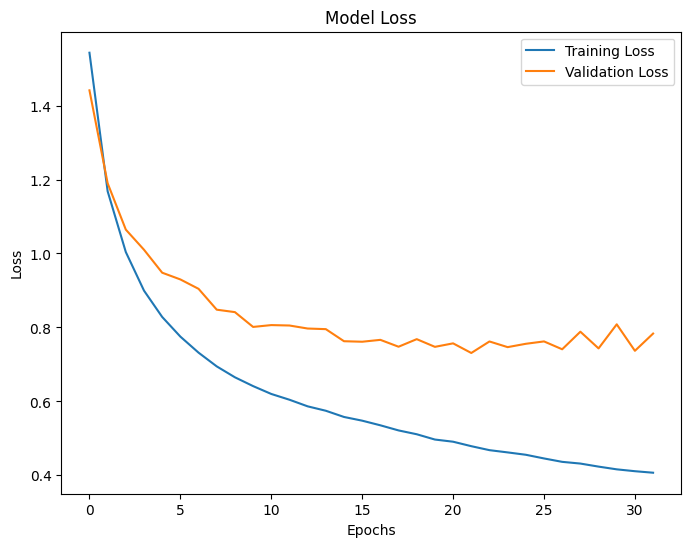

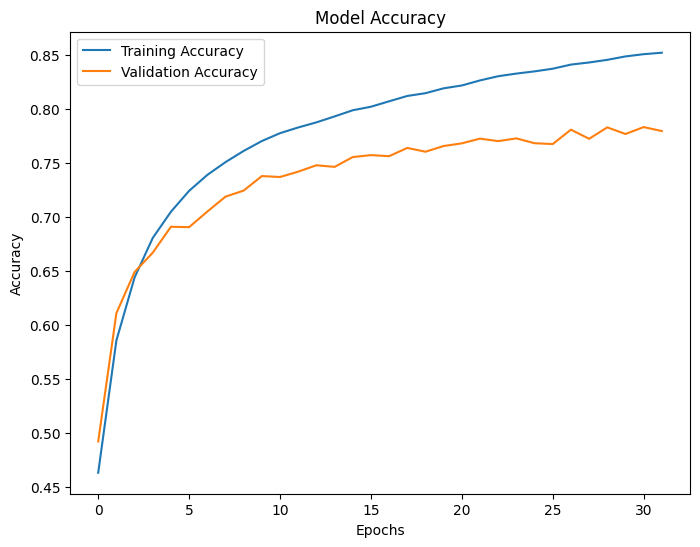

In [16]:
history = cnn

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

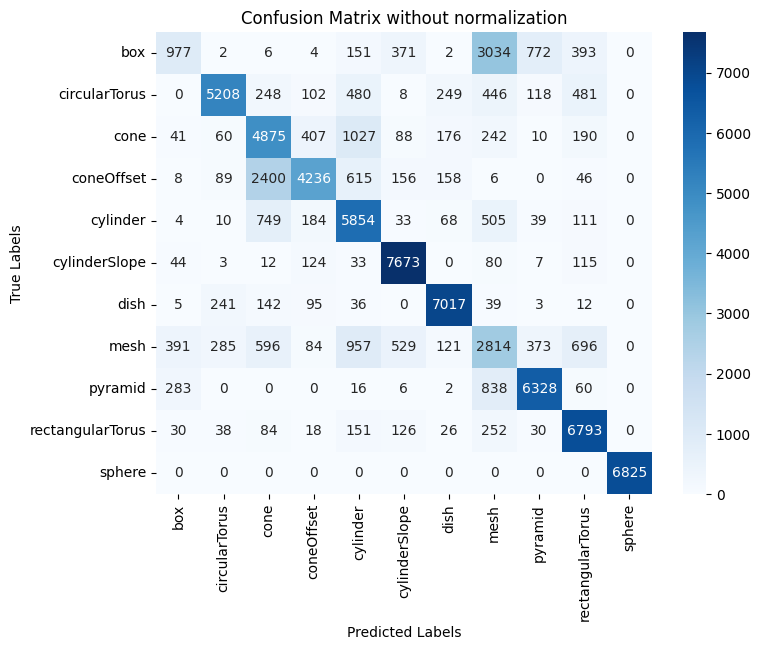

In [18]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix without normalization')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

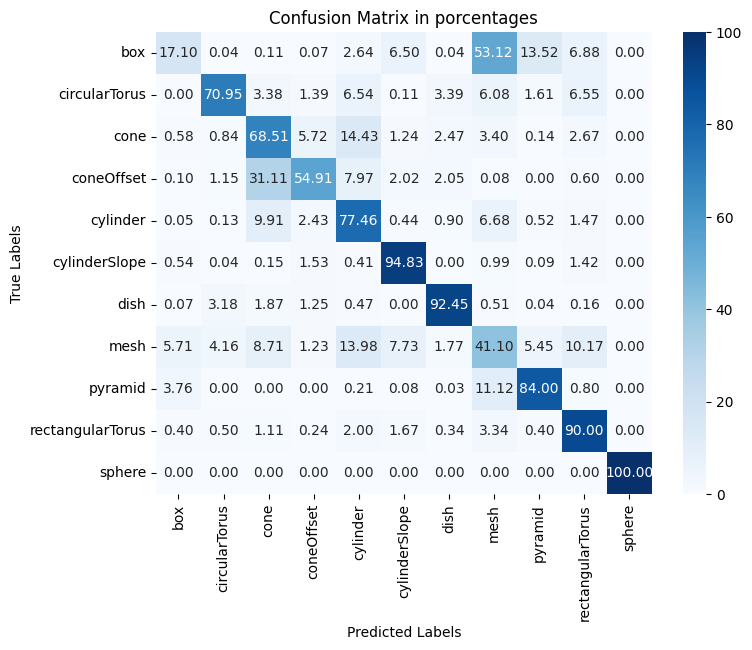

In [19]:

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix in porcentages')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
